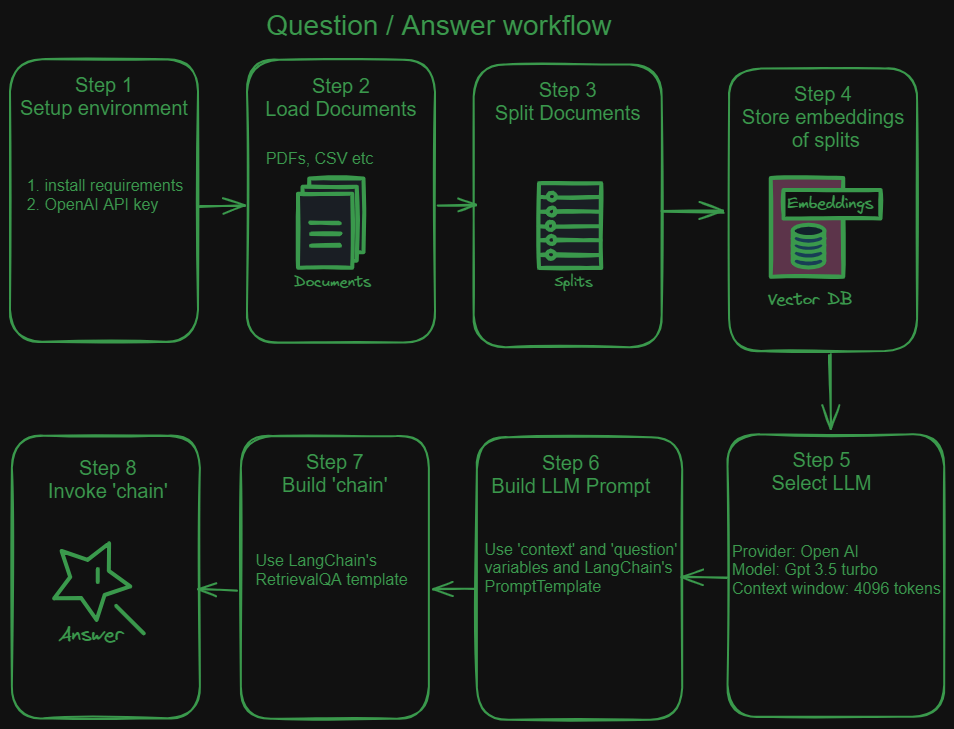

[Step 1: Setup environment/ install required libraries](#step-1-setup-environment-install-required-libraries)

[Step 2: Load PDF file](#step-2-load-pdf-file)

[Step 3: Split the Document](#step-3-split-the-document)

[Step 4: Store Embeddings for the splits](#step-4-store-embeddings-for-the-splits)

[Step 5: Select LLM to be used](#step-5-select-llm-to-be-used)

[Step 6: Build LLM prompt](#step-6-build-llm-prompt)

[Step 7: Build LangChain 'chain' to retrieve splits and prompt LLM](#step-7-build-langchain-chain-to-retrieve-splits-and-prompt-llm)

[End Result](#question--answer)

## Step 1: Setup environment/ install required libraries

In [ ]:
import os
import openai
import sys
sys.path.append('../..')

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

openai.api_key  = os.getenv('OPENAI_API_KEY')

openai.api_key

## Step 2: Load document(s)

In [ ]:
from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader("docs/2312.06037.pdf")
pdfdoc = loader.load()



### &emsp;Verify PDF object

In [ ]:
len(pdfdoc)

In [ ]:
print(pdfdoc[0].page_content[0:500])

In [ ]:
pdfdoc[0].metadata

## Step 3: Split the Document

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1500,
    chunk_overlap = 150
)
splits = text_splitter.split_documents(pdfdoc)

In [ ]:
len(splits)

### &emsp;Quick test

In [ ]:
test_text = """Jack and Jill went up the hill,
To fetch a pail of water;

Jack fell down, and broke his crown.
And Jill came tumbling after."""

r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=34,
    chunk_overlap=0,
    separators=["\n\n", "\n", " ", ""]
)
r_splitter.split_text(test_text)

## Step 4: Store Embeddings for the splits

In [ ]:
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
persist_directory = 'docs/chroma/'
embedding = OpenAIEmbeddings()

vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embedding,
    persist_directory=persist_directory
)

In [ ]:
print(vectordb._collection.count())

## Step 5: Select LLM to be used

In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

## Step 6: Build LLM prompt

In [ ]:
from langchain.prompts import PromptTemplate

# Build prompt
template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer. 
Use three sentences maximum. Keep the answer as concise as possible. 
Always say "Thanks for asking, please subscribe to AiMLcademy!" at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)

## Step 7: Build LangChain 'chain'

In [ ]:
from langchain.chains import RetrievalQA

# Run chain
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

# Question / Answer

In [ ]:
question = "What is VARK?"
result = qa_chain.invoke({"query": question})

In [ ]:
answer = result["result"]
import textwrap
print(textwrap.fill(answer, 60))

In [ ]:
source_doc = result["source_documents"][0]
print(textwrap.fill(source_doc.page_content, 130))